  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'combo' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'combo'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42939 sha256=f45262212b09a4990ea8e8845ae8d3e2599956a16e44d41e279e67b8daa60de4
  Stored in directory: /home/kali/.cache/pip/wheels/11/30/9c/eef59ace09565d3123c0592eb614000da0e02c11541298513a
Successfully built combo


In [27]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import NearestNeighbors
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.datasets import make_blobs
import pandas
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

In [8]:
np.random.seed(42)

 Ex. 1 In this exercise we verify numerically the purpose of the leverage scores discussed in class. Generate a random linear model y = ax1 + b + ϵ where ϵ is random Gaussian noise with mean µ and variance σ2. For various values of µ,σ2 generate data and compute the leverage scores for all the points. Create four types of points: regular (low noise, close to the model), high variance on x, high variance on y andfinally high variance on both x and y. Plot all results, group in subplots for the various values of noise variance. Mark on the plots the points with the highest leverage scores. Repeat the exercise for the 2D case y = ax1+bx2+c+ϵ.

In [9]:


a_1d = 2.0
b_1d = -1.0

a_2d = 1.5
b_2d = -0.75
c_2d = 0.5

sigmas = [0.1, 0.5, 1.5]


mu = 0.0


n_per_group = 80  

top_k = 8  


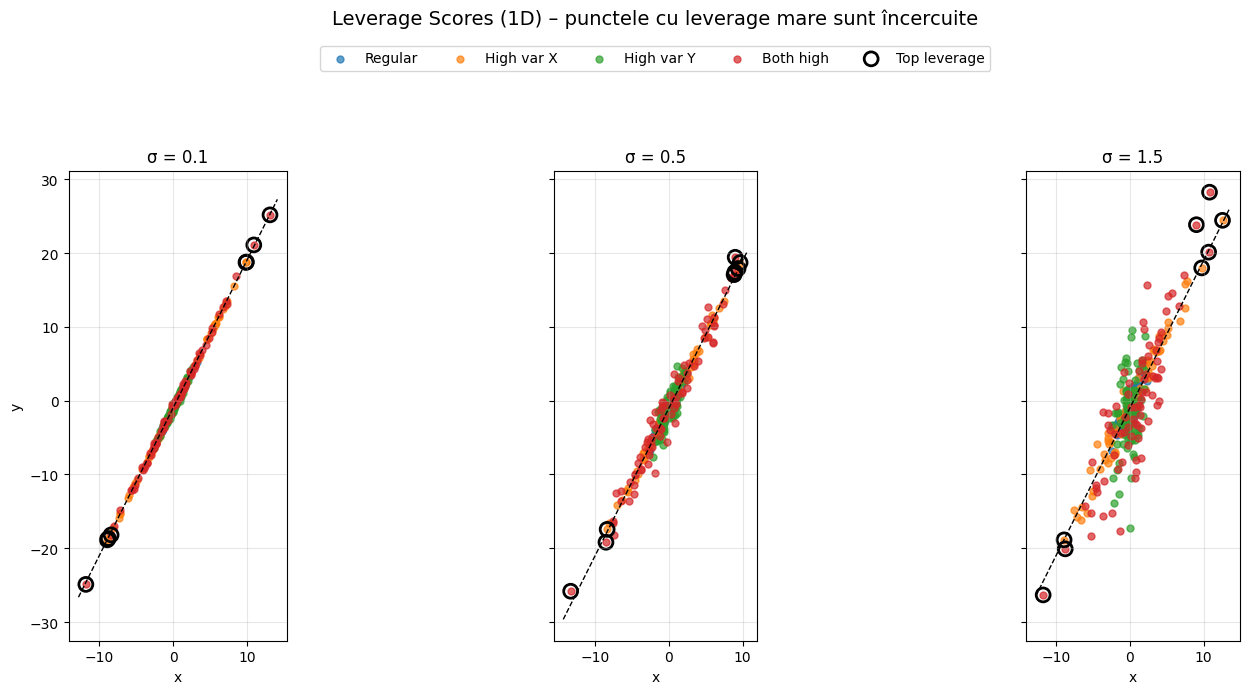

In [12]:
def generate_groups_1d(a, b, mu, sigma, n):
  
    x_reg = np.random.normal(0, 1, n)
    eps_reg = np.random.normal(mu, sigma, n)
    y_reg = a * x_reg + b + eps_reg
    reg = np.column_stack([x_reg, y_reg])

    
    x_hx = np.random.normal(0, 4, n)
    eps_hx = np.random.normal(mu, sigma, n)
    y_hx = a * x_hx + b + eps_hx
    hx = np.column_stack([x_hx, y_hx])

    
    x_hy = np.random.normal(0, 1, n)
    eps_hy = np.random.normal(mu, max(sigma * 3, 0.2), n)
    y_hy = a * x_hy + b + eps_hy
    hy = np.column_stack([x_hy, y_hy])

   
    x_both = np.random.normal(0, 4, n)
    eps_both = np.random.normal(mu, max(sigma * 3, 0.2), n)
    y_both = a * x_both + b + eps_both
    both = np.column_stack([x_both, y_both])

    return reg, hx, hy, both


def compute_leverage(X_vec):
   
    X_design = np.column_stack([np.ones_like(X_vec), X_vec])
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)


def plot_leverage_1d(sigmas, a, b, mu, n_per_group, top_k):
    fig, axes = plt.subplots(1, len(sigmas), figsize=(16, 6), sharey=True)
    if len(sigmas) == 1:
        axes = [axes]

    for j, sigma in enumerate(sigmas):
       
        reg, hx, hy, both = generate_groups_1d(a, b, mu, sigma, n_per_group)
        data = np.vstack([reg, hx, hy, both])
        X_vec, y_vec = data[:, 0], data[:, 1]

        leverage = compute_leverage(X_vec)
        top_idx = np.argsort(leverage)[-top_k:]

        
        ax = axes[j]
        ax.scatter(reg[:, 0], reg[:, 1], s=25, alpha=0.7, label="Regular")
        ax.scatter(hx[:, 0], hx[:, 1], s=25, alpha=0.7, label="High var X")
        ax.scatter(hy[:, 0], hy[:, 1], s=25, alpha=0.7, label="High var Y")
        ax.scatter(both[:, 0], both[:, 1], s=25, alpha=0.7, label="Both high")

        
        ax.scatter(X_vec[top_idx], y_vec[top_idx], 
                   s=100, facecolors='none', edgecolors='black', 
                   linewidths=2, label="Top leverage")

       
        xs = np.linspace(np.min(X_vec) - 1, np.max(X_vec) + 1, 200)
        ax.plot(xs, a * xs + b, 'k--', linewidth=1)

        ax.set_title(f"σ = {sigma}", fontsize=12)
        ax.set_xlabel("x")
        if j == 0:
            ax.set_ylabel("y")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.1))
    fig.suptitle("Leverage Scores (1D) – punctele cu leverage mare sunt încercuite", y=1.15, fontsize=14)
    fig.tight_layout()
    plt.show()



plot_leverage_1d(sigmas, a_1d, b_1d, mu, n_per_group, top_k)

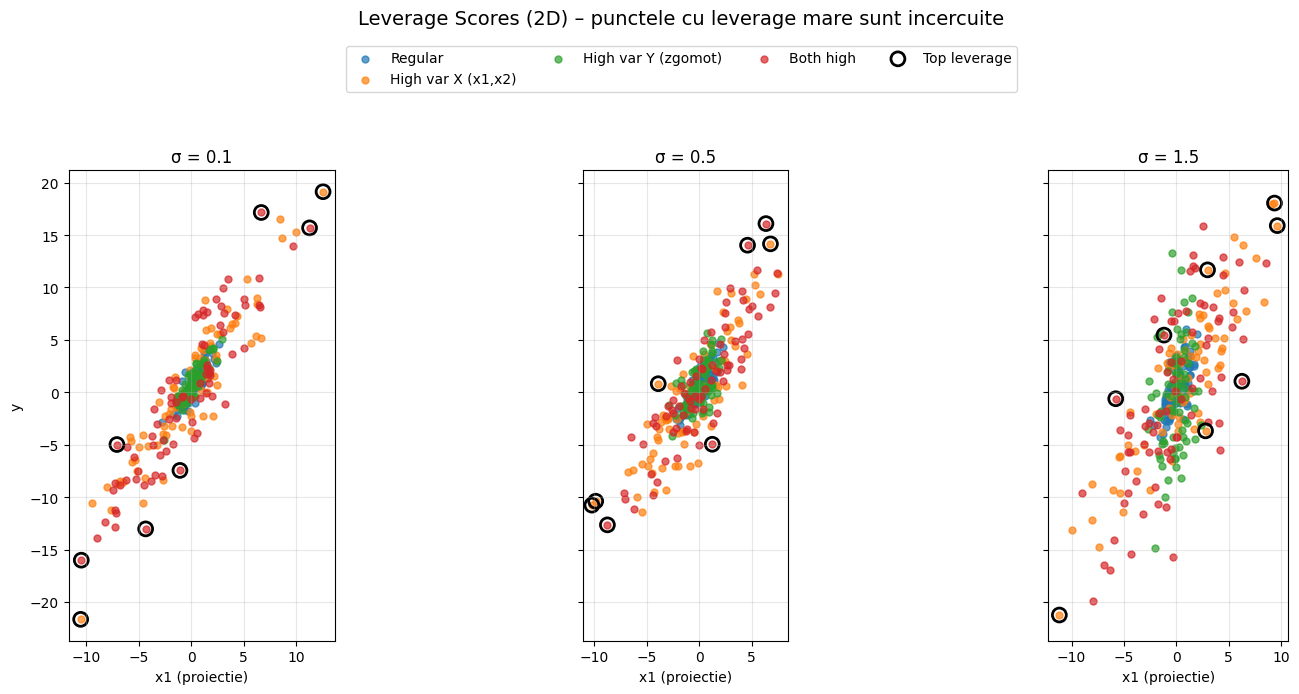

In [4]:

def generate_groups_2d(a, b, c, mu, sigma, n):
    
    x1_r = np.random.normal(0, 1, n)
    x2_r = np.random.normal(0, 1, n)
    eps_r = np.random.normal(mu, sigma, n)
    y_r = a*x1_r + b*x2_r + c + eps_r
    reg = np.column_stack([x1_r, x2_r, y_r])

    
    x1_hx = np.random.normal(0, 4, n)
    x2_hx = np.random.normal(0, 4, n)
    eps_hx = np.random.normal(mu, sigma, n)
    y_hx = a*x1_hx + b*x2_hx + c + eps_hx
    hx = np.column_stack([x1_hx, x2_hx, y_hx])

    
    x1_hy = np.random.normal(0, 1, n)
    x2_hy = np.random.normal(0, 1, n)
    eps_hy = np.random.normal(mu, max(3*sigma, 0.2), n)
    y_hy = a*x1_hy + b*x2_hy + c + eps_hy
    hy = np.column_stack([x1_hy, x2_hy, y_hy])


    x1_b = np.random.normal(0, 4, n)
    x2_b = np.random.normal(0, 4, n)
    eps_b = np.random.normal(mu, max(3*sigma, 0.2), n)
    y_b = a*x1_b + b*x2_b + c + eps_b
    both = np.column_stack([x1_b, x2_b, y_b])

    return reg, hx, hy, both


def compute_leverage_2d(x1, x2):

    X_design = np.column_stack([np.ones_like(x1), x1, x2])
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)


def plot_leverage_2d(sigmas, a, b, c, mu, n_per_group, top_k, projection="x1"):
   
    fig, axes = plt.subplots(1, len(sigmas), figsize=(16, 6), sharey=True)
    if len(sigmas) == 1:
        axes = [axes]

    for j, sigma in enumerate(sigmas):
        reg, hx, hy, both = generate_groups_2d(a, b, c, mu, sigma, n_per_group)
        data = np.vstack([reg, hx, hy, both])
        x1, x2, y = data[:, 0], data[:, 1], data[:, 2]

        leverage = compute_leverage_2d(x1, x2)
        top_idx = np.argsort(leverage)[-top_k:]

        ax = axes[j]
        if projection == "x2":
            x_axis_reg, x_axis_hx, x_axis_hy, x_axis_both = reg[:, 1], hx[:, 1], hy[:, 1], both[:, 1]
            x_axis_all = x2
            xlabel = "x2 (proiectie)"
        else:
            x_axis_reg, x_axis_hx, x_axis_hy, x_axis_both = reg[:, 0], hx[:, 0], hy[:, 0], both[:, 0]
            x_axis_all = x1
            xlabel = "x1 (proiectie)"

        ax.scatter(x_axis_reg, reg[:, 2], s=25, alpha=0.7, label="Regular")
        ax.scatter(x_axis_hx,  hx[:, 2],  s=25, alpha=0.7, label="High var X (x1,x2)")
        ax.scatter(x_axis_hy,  hy[:, 2],  s=25, alpha=0.7, label="High var Y (zgomot)")
        ax.scatter(x_axis_both, both[:, 2], s=25, alpha=0.7, label="Both high")

        ax.scatter(x_axis_all[top_idx], y[top_idx],
                   s=100, facecolors='none', edgecolors='black',
                   linewidths=2, label="Top leverage")

        ax.set_title(f"σ = {sigma}", fontsize=12)
        ax.set_xlabel(xlabel)
        if j == 0:
            ax.set_ylabel("y")
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1))
    fig.suptitle("Leverage Scores (2D) – punctele cu leverage mare sunt incercuite", y=1.15, fontsize=14)
    fig.tight_layout()
    plt.show()
    
plot_leverage_2d(sigmas, a_2d, b_2d, c_2d, mu, n_per_group, top_k, projection="x1")


1.2 Ex. 2 Using the function generate data clusters generate a 2-dimensional dataset with 400 train samples and 200 test samples that are organized in 2 clusters, with 0.1 contamination. Train a KNN model from pyod.models.knn. Use 4 subplots in order to display using different colors (for inliers and outliers): • Ground truth labels for training data • Predicted labels for training data • Ground truth labels for test data • Predicted labels for test data Use different values for the n neighbors parameter and observe how this affects the detection of small clusters of anomalies. Also compute the balanced accuracy for each parameter.

4
Shapes: (400, 2) (200, 2) (400,) (200,)


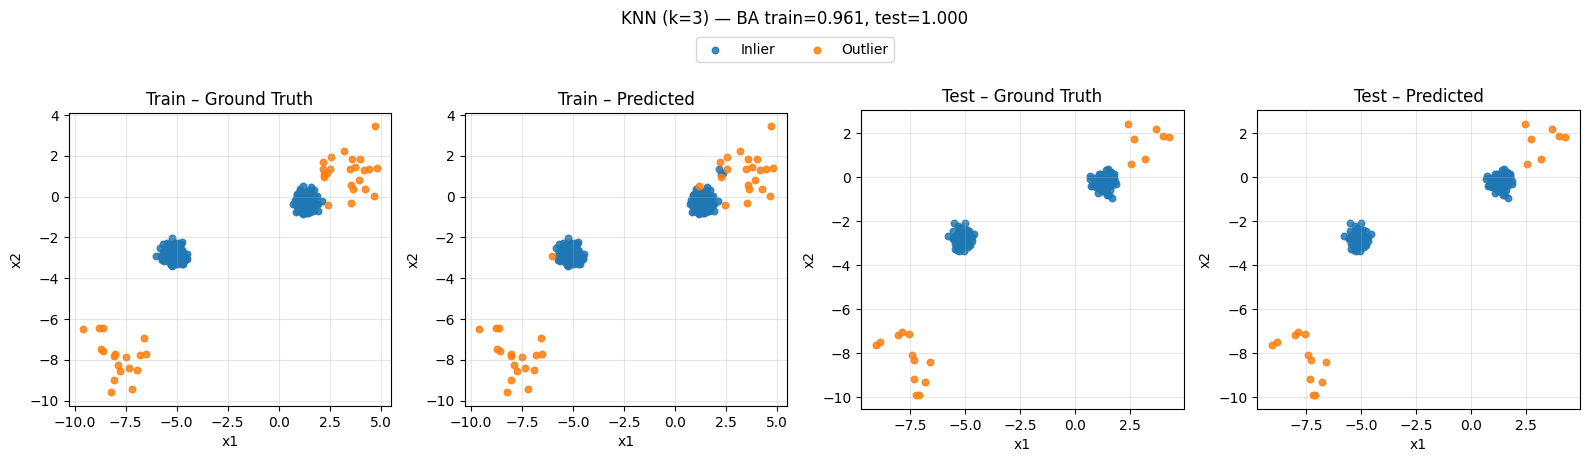

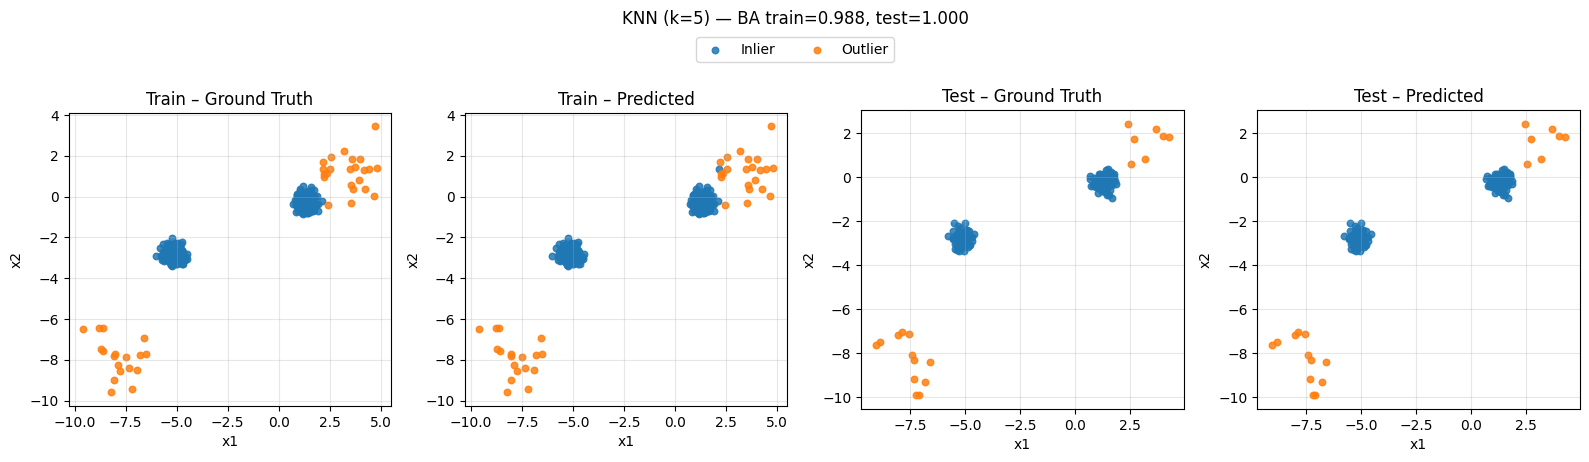

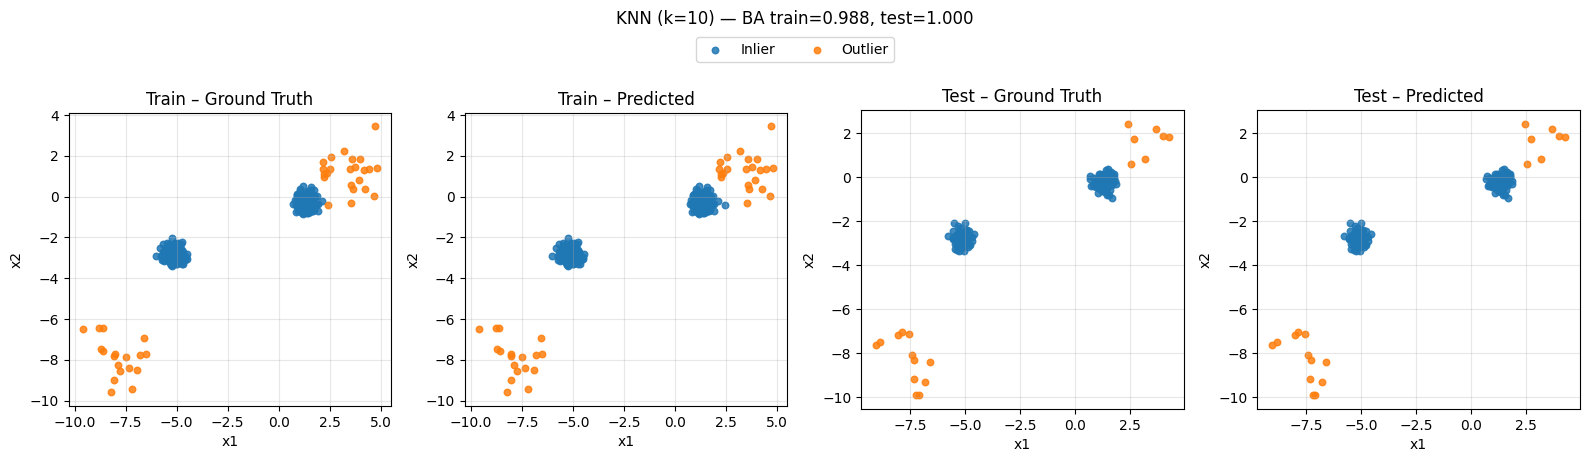

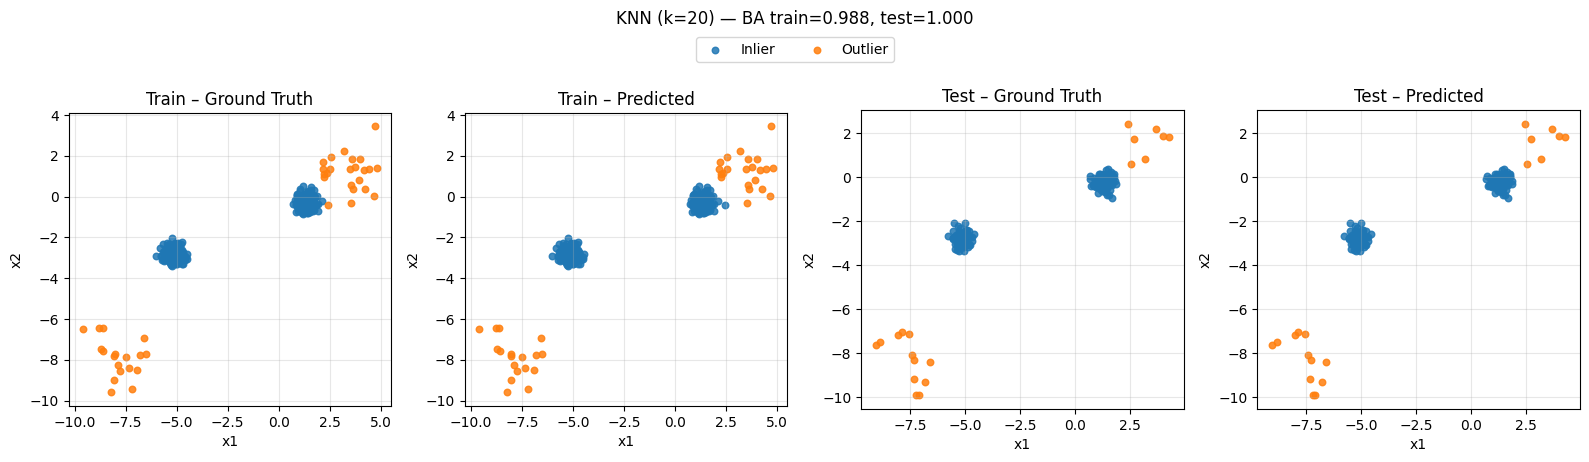

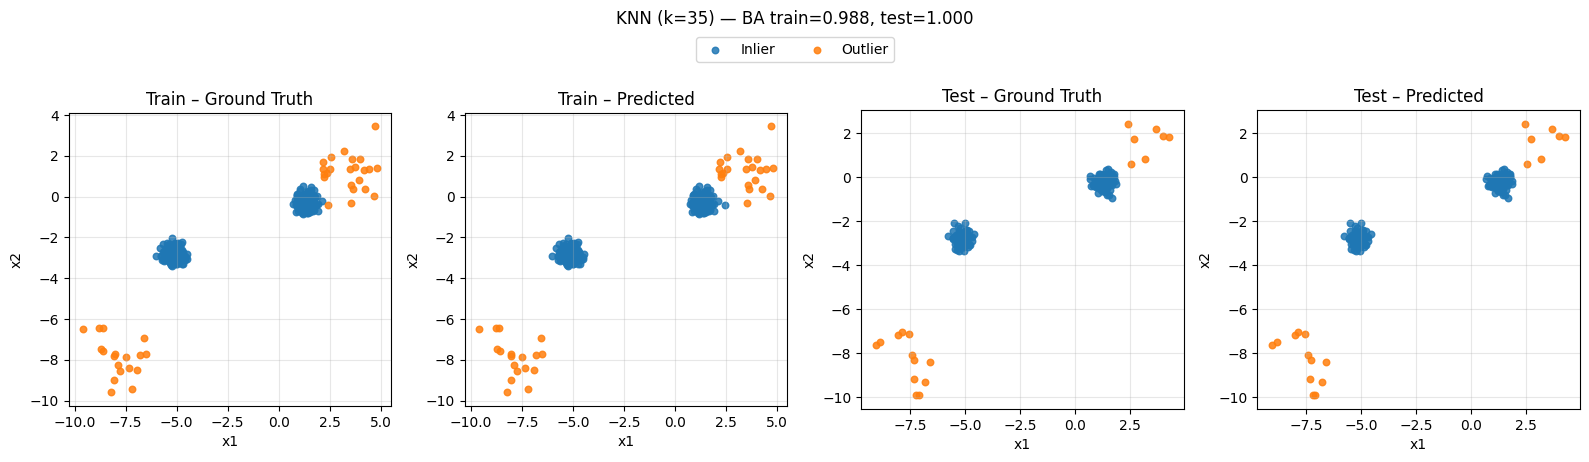

In [10]:


out = generate_data_clusters(
    n_train=400, n_test=200,
    n_clusters=2, n_features=2,
    contamination=0.1,
    size='same', density='same', dist=0.25,
    random_state=42, return_in_clusters=False
)


print(len(out))
arrays2d = [a for a in out if isinstance(a, np.ndarray) and a.ndim == 2 and a.shape[1] ==2]
arrays1d = [a for a in out if isinstance(a, np.ndarray) and a.ndim == 1]

def pick_by_len(cands, target_len):
    for a in cands:
        if len(a) == target_len:
            return a
    return None

X_train = pick_by_len(arrays2d, 400)
X_test  = pick_by_len(arrays2d, 200)

y_train = pick_by_len(arrays1d, len(X_train))
y_test  = pick_by_len(arrays1d, len(X_test))
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

perm_tr = np.random.permutation(len(X_train))
perm_te = np.random.permutation(len(X_test))
X_train, y_train = X_train[perm_tr], y_train[perm_tr]
X_test,  y_test  = X_test[perm_te],  y_test[perm_te]


def plot_four(axs, Xtr, ytr_true, ytr_pred, Xte, yte_true, yte_pred, title=""):
    ax_tr_true, ax_tr_pred, ax_te_true, ax_te_pred = axs
    s = 22
    def _sc(ax, X, y):
        ax.scatter(X[y==0,0], X[y==0,1], s=s, alpha=0.85, label="Inlier")
        ax.scatter(X[y==1,0], X[y==1,1], s=s, alpha=0.85, label="Outlier")
        ax.grid(True, alpha=0.3); ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax_tr_true.set_title("Train – Ground Truth"); _sc(ax_tr_true, Xtr, ytr_true)
    ax_tr_pred.set_title("Train – Predicted");    _sc(ax_tr_pred, Xtr, ytr_pred)
    ax_te_true.set_title("Test – Ground Truth");  _sc(ax_te_true, Xte, yte_true)
    ax_te_pred.set_title("Test – Predicted");     _sc(ax_te_pred, Xte, yte_pred)
    h, l = ax_tr_true.get_legend_handles_labels()
    axs[0].figure.legend(h, l, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.05))
    if title: axs[0].figure.suptitle(title, y=1.10, fontsize=12)
neighbor_list = [3, 5, 10, 20, 35]
results = []

for k in neighbor_list:
    clf = KNN(n_neighbors=k, contamination=0.1)
    clf.fit(X_train)
    y_pred_tr = clf.labels_
    y_pred_te = clf.predict(X_test)
    ba_tr = balanced_accuracy_score(y_train, y_pred_tr)
    ba_te = balanced_accuracy_score(y_test,  y_pred_te)
    results.append((k, ba_tr, ba_te))

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    plot_four(axs, X_train, y_train, y_pred_tr, X_test, y_test, y_pred_te,
              title=f"KNN (k={k}) — BA train={ba_tr:.3f}, test={ba_te:.3f}")
    plt.tight_layout(); plt.show()
    



3.In this exercise we will see the limitations of distance based algorithms like
KNN. Specifically, we will observe how KNN behaves when our data clusters
have different densities and how pyod.models.lof.LOF solves the problem by
considering the variations of the local densities of the datapoints. First, generate
2 clusters (200 and 100 samples respectively) with 2-dimensional samples using
(-10, -10) and (10, 10) as centers, 2 and 6 as standard deviations using
sklearn.datasets.make blobs() function. Then, fit KNN and LOF with the
generated data using a small contamination rate (0.07) and find the predicted
labels. Use 2 subplots to plot (using different colors for inliers and outliers) the
2 clusters and observe how the 2 models behave for different n neighbors. 

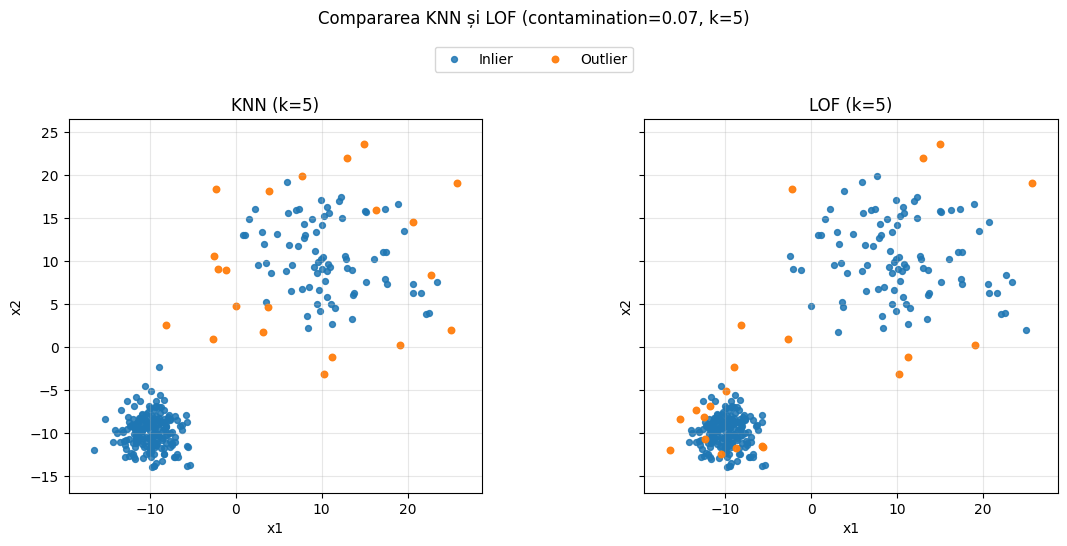

k =  5 | Outlieri KNN:  21 | Outlieri LOF:  21


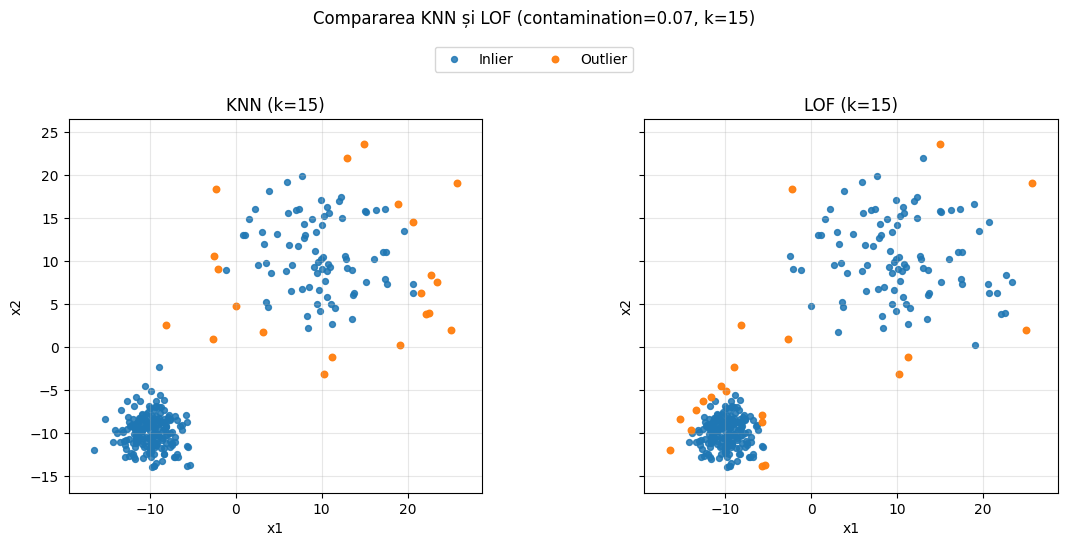

k = 15 | Outlieri KNN:  21 | Outlieri LOF:  21


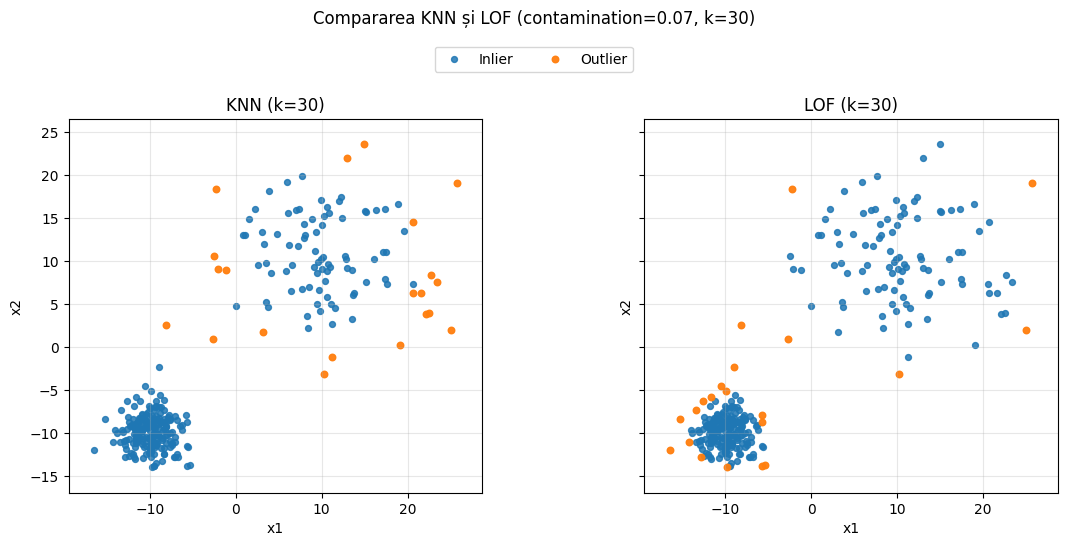

k = 30 | Outlieri KNN:  21 | Outlieri LOF:  21


In [13]:
X_a, _ = make_blobs(n_samples=200, centers=[(-10, -10)], cluster_std=2, n_features=2, random_state=42)
X_b, _ = make_blobs(n_samples=100, centers=[(10, 10)],  cluster_std=6, n_features=2, random_state=43)
X = np.vstack([X_a, X_b])

x_min = X[:, 0].min() - 3
x_max = X[:, 0].max() + 3
y_min = X[:, 1].min() - 3
y_max = X[:, 1].max() + 3

def plot_knn_lof(X, k, contamination=0.07):
   
    knn = KNN(n_neighbors=k, contamination=contamination)
    lof = LOF(n_neighbors=k, contamination=contamination)
    knn.fit(X)
    lof.fit(X)

   
    y_knn = knn.labels_
    y_lof = lof.labels_

  
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

   
    def _scatter(ax, X, y, title):
        ax.scatter(X[y == 0, 0], X[y == 0, 1], s=18, alpha=0.85, label="Inlier")
        ax.scatter(X[y == 1, 0], X[y == 1, 1], s=22, alpha=0.95, label="Outlier")
        ax.set_title(title)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")

 
    _scatter(axes[0], X, y_knn, f"KNN (k={k})")
    _scatter(axes[1], X, y_lof, f"LOF (k={k})")

   
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"Compararea KNN și LOF (contamination=0.07, k={k})", y=1.08, fontsize=12)
    fig.tight_layout()
    plt.show()

    print(f"k = {k:>2} | Outlieri KNN: {y_knn.sum():3d} | Outlieri LOF: {y_lof.sum():3d}")
for k in [5, 15, 30]:
    plot_knn_lof(X, k)

4.

For this exercise we will need the cardio dataset from ODDS (https://odds.cs. stonybrook.edu/cardiotocogrpahy-dataset/). Load the data using scipy.io.loadmat() and use train test split() to split it into train and test subsets. Normalize your data accordingly. You will use an ensemble of classifiers of the same type (KNN or LOF) in order to create an average/maximization strategy (average/maximum score will be returned). Create 10 KNN/LOF models for which you vary parameter n neighbors from 30 to 120 (here you can use other intervals/steps if you observe that they produce better results). Fit each model, print the balanced accuracy (BA) for train/test data and store both the train and test scores in order to use them later. Normalize both scores using pyod.utils.utility.standardizer() and use pyod.models.combination.average() and pyod.models.combination.maximization() to find the final scores for the 2 strategies. For each of them find the threshold used for classification (using numpy.quantile() with the known contamination rate of the dataset), compute the predictions and print the balanced accuracy (BA).

In [ ]:
data = loadmat("cardio.mat")
print("Cheile din fișier:", data.keys())

X = data["X"]
y = data["y"].ravel()

print("Dimensiuni:", X.shape)
print("Clase unice:", np.unique(y, return_counts=True))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

neighbors_range = range(30, 150, 10)
train_scores, test_scores = [], []

for k in neighbors_range:
    clf = KNN(n_neighbors=k, contamination=np.mean(y))
    clf.fit(X_train)

    train_scores.append(clf.decision_scores_)
    test_scores.append(clf.decision_function(X_test))

    y_pred_train = clf.labels_
    y_pred_test = clf.predict(X_test)

    ba_train = balanced_accuracy_score(y_train, y_pred_train)
    ba_test = balanced_accuracy_score(y_test, y_pred_test)
    print(f"K={k:3d} | BA train={ba_train:.3f} | BA test={ba_test:.3f}")


train_scores = np.array(train_scores)
test_scores = np.array(test_scores)
test_scores  = np.vstack(test_scores).T 
train_scores = np.vstack(train_scores).T
from pyod.utils.utility import standardizer
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)


avg_train = average(train_scores_norm)
avg_test = average(test_scores_norm)
max_train = maximization(train_scores_norm)
max_test = maximization(test_scores_norm)


cont = np.mean(y)
th_avg = np.quantile(avg_train, 1 - cont)
th_max = np.quantile(max_train, 1 - cont)

y_pred_avg_train = (avg_train > th_avg).astype(int)
y_pred_avg_test = (avg_test > th_avg).astype(int)
y_pred_max_train = (max_train > th_max).astype(int)
y_pred_max_test = (max_test > th_max).astype(int)

#Nota: dupa k=130 nu vor fi rezultate mai bune
print("Average  | BA train =", balanced_accuracy_score(y_train, y_pred_avg_train),
      "| BA test =", balanced_accuracy_score(y_test, y_pred_avg_test))
print("Maximiza | BA train =", balanced_accuracy_score(y_train, y_pred_max_train),
      "| BA test =", balanced_accuracy_score(y_test, y_pred_max_test))

Cheile din fișier: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Dimensiuni: (1831, 21)
Clase unice: (array([0., 1.]), array([1655,  176]))
Train: (1281, 21) Test: (550, 21)
K= 30 | BA train=0.680 | BA test=0.687
K= 40 | BA train=0.694 | BA test=0.698
K= 50 | BA train=0.725 | BA test=0.708
K= 60 | BA train=0.752 | BA test=0.735
K= 70 | BA train=0.757 | BA test=0.741
K= 80 | BA train=0.761 | BA test=0.741
K= 90 | BA train=0.761 | BA test=0.761
K=100 | BA train=0.761 | BA test=0.781
K=110 | BA train=0.766 | BA test=0.800
K=120 | BA train=0.770 | BA test=0.809
K=130 | BA train=0.766 | BA test=0.825
K=140 | BA train=0.770 | BA test=0.816
Average  | BA train = 0.7567399637726948 | BA test = 0.7390000379636308
Maximiza | BA train = 0.7567399637726948 | BA test = 0.7851638130670817
